- 격자이름 고유한 것만 남기기 (완료)
  2. 겹치는 구를 하나의 문자열로 만들어서 저장
 
- 교통사고 분포가 너무 차이가 크고 고르지 않음

# 라이브러리 설치

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.9 MB/s eta 0:00:00


In [ ]:
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 라이브러리 및 경로 설정


In [ ]:
import geopandas as gpd
import pandas as pd

In [ ]:
src_path = '/content/drive/MyDrive/sk쉴더스/프로젝트1/데이터/'

# 데이터 로드

In [ ]:
grids = pd.read_csv(src_path + 'unique_grid.csv')
accidents = pd.read_csv(src_path + '교통사고 데이터/교통사고데이터.csv', encoding='cp949')

In [ ]:
grids.head(2)

,gid,lbl,val,geometry,gu
0,다사58a48a,6085.0,6085.0,"POLYGON ((958000 1948000, 958000 1948500, 9585...",강남구
1,다사58b48a,3446.0,3446.0,"POLYGON ((958500 1948000, 958500 1948500, 9590...",강남구


In [ ]:
grids[grids['gid']=='다사65a49a']

,gid,lbl,val,geometry,gu
315,다사65a49a,NaN,NaN,"POLYGON ((965000 1949000, 965000 1949500, 9655...",강동구 광진구 송파구


In [ ]:
accidents = accidents[['acdnt_no', 'x_crdnt', 'y_crdnt']]

In [ ]:
accidents.head(2)

,acdnt_no,x_crdnt,y_crdnt
0,2021010100100001,948902,1955807
1,2021010100100002,947601,1946291


# pandas ⟶ geopandas

## 격자지도 데이터프레임

```
기존에 .shp을 로드해서 csv로 저장했기 때문에 'geometry'열이 존재한다.

그러나 csv로 저장하면서 기존에 'geometry'열의 데이터 타입이 문자열로 변경되었다.

따라서 wkt.loads를 이용해서 문자열 타입을 폴리곤 타입으로 바꾸고, geodataframe을 구성할 때 좌표계 정보(epsg:5179)를 주었다.
```

In [ ]:
from shapely import wkt

grids['geometry'] = grids['geometry'].apply(wkt.loads)
geo_grids = gpd.GeoDataFrame(grids, crs='epsg:5179')

In [ ]:
geo_grids.head(2)

,gid,lbl,val,geometry,gu
0,다사58a48a,6085.0,6085.0,"POLYGON ((958000.000 1948000.000, 958000.000 1...",강남구
1,다사58b48a,3446.0,3446.0,"POLYGON ((958500.000 1948000.000, 958500.000 1...",강남구


## 교통사고 데이터프레임

```
기존에 .csv 파일이었기 때문에 'geometry'열이 존재하지 않는다.

따라서 geodataframe을 구성할 때 x좌표와 y좌표를 이용하여 'geometry' 컬럼을 만들어준다. 

그 후 set_crs() 함수를 이용해 좌표계를 5179 좌표계로 설정한다.

좌표계 설정 이유 : 좌표계의 종류가 많기 때문에 어떤 종류의 좌표계인지 명시해주어야 함
```

In [ ]:
geo_accidents = gpd.GeoDataFrame(
    accidents, geometry=gpd.points_from_xy(accidents['x_crdnt'], accidents['y_crdnt'])
)
geo_accidents.set_crs(epsg = 5179, inplace = True)

,acdnt_no,x_crdnt,y_crdnt,geometry
0,2021010100100001,948902,1955807,POINT (948902.000 1955807.000)
1,2021010100100002,947601,1946291,POINT (947601.000 1946291.000)
2,2021010100100003,960506,1959311,POINT (960506.000 1959311.000)
3,2021010100100014,955647,1952490,POINT (955647.000 1952490.000)
4,2021010100100015,958051,1959152,POINT (958051.000 1959152.000)
...,...,...,...,...
33908,2021123100100598,962390,1955878,POINT (962390.000 1955878.000)
33909,2021123100100599,967028,1941901,POINT (967028.000 1941901.000)
33910,2021123100100600,956172,1946116,POINT (956172.000 1946116.000)
33911,2021123100100624,958920,1951366,POINT (958920.000 1951366.000)


In [ ]:
geo_accidents.head(2)

,acdnt_no,x_crdnt,y_crdnt,geometry
0,2021010100100001,948902,1955807,POINT (948902.000 1955807.000)
1,2021010100100002,947601,1946291,POINT (947601.000 1946291.000)


# 교통사고가 어떤 격자에서 일어났는지

In [ ]:
# 여러 열 중에 쓰는 열만
geo_grids = geo_grids[['gid', 'geometry', 'gu']]
display(geo_grids.head(2), geo_grids.shape)

,gid,geometry,gu
0,다사58a48a,"POLYGON ((958000.000 1948000.000, 958000.000 1...",강남구
1,다사58b48a,"POLYGON ((958500.000 1948000.000, 958500.000 1...",강남구


(2634, 3)

In [ ]:
# 여러 열 중에 쓰는 열만
geo_accidents = geo_accidents[['acdnt_no', 'geometry']]
display(geo_accidents.head(2), geo_accidents.shape)

,acdnt_no,geometry
0,2021010100100001,POINT (948902.000 1955807.000)
1,2021010100100002,POINT (947601.000 1946291.000)


(33913, 2)

## geopandas 의 sjoin을 사용

- 정확히는 모르지만 공간에 따라 데이터를 join 하는 것 같음
- pandas.join과 유사 ( 다른 점: pandas의 join은 데이터가 같은 것끼리 엮지만 geopandas의 sjoin은 공간이 겹치면 엮는다 )

In [ ]:
# sjoin 이용해서 공간 결합!
# for문을 돌면 너무 많이 돌아야해서 시간이 너무 오래 걸림
join_geo_df = gpd.sjoin(geo_accidents, geo_grids, how='left')
join_geo_df.shape

(34038, 5)

In [ ]:
# 교통사고가 33913 건이고 각각 어디 격자에서 일어났는지 sjoin 하였다
# 그 결과 데이터가 34038 건이 되었다.
# 중복되는 행은 아래와 같음
join_geo_df[join_geo_df['acdnt_no'].duplicated()]

,acdnt_no,geometry,index_right,gid,gu
133,2021010300100200,POINT (954000.000 1951742.000),2558.0,다사53b51b,중구
246,2021010500100346,POINT (957272.000 1952000.000),2500.0,다사57a52a,종로구 중구
394,2021010700100079,POINT (958591.000 1956500.000),345.0,다사58b56b,강북구 성북구
469,2021010800100205,POINT (963500.000 1954899.000),2589.0,다사63a54b,중랑구
614,2021010900100479,POINT (947500.000 1947860.000),2191.0,다사47a47b,영등포구
...,...,...,...,...,...
32692,2021121800100451,POINT (969500.000 1948937.000),285.0,다사69b48b,강동구
32856,2021122000100505,POINT (943254.000 1944000.000),988.0,다사43a44a,구로구
33010,2021122200100168,POINT (964000.000 1945889.000),2013.0,다사63b45b,송파구
33196,2021122400100025,POINT (959331.000 1956000.000),1973.0,다사59a56a,성북구


In [ ]:
join_geo_df[join_geo_df['acdnt_no']==2021010500100346]

,acdnt_no,geometry,index_right,gid,gu
246,2021010500100346,POINT (957272.000 1952000.000),2563.0,다사57a51b,중구
246,2021010500100346,POINT (957272.000 1952000.000),2500.0,다사57a52a,종로구 중구


In [ ]:
# 사고 번호의 고유한 값을 찍어보면 33913 건 
len(join_geo_df['acdnt_no'].unique())

33913

# 격자별 사고 건수

## sjoin 후 결측치 확인

In [ ]:
# 결측치가 존재
join_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 34038 entries, 0 to 33912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   acdnt_no     34038 non-null  int64   
 1   geometry     34038 non-null  geometry
 2   index_right  34027 non-null  float64 
 3   gid          34027 non-null  object  
 4   gu           34027 non-null  object  
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
# 결측치 데이터들이 격자 영역을 아주 살짝 벗어나는 것 같음 -> 무시하기로 결정
null_join_geo_df = join_geo_df[join_geo_df['gid'].isnull()]
null_join_geo_df.explore(tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', attr='Google')

In [ ]:
# 결측치 있는 행 제거
join_geo_df = join_geo_df[~join_geo_df['gid'].isnull()]
join_geo_df.head(2)

,acdnt_no,geometry,index_right,gid,gu
0,2021010100100001,POINT (948902.000 1955807.000),2426.0,다사48b55b,은평구
1,2021010100100002,POINT (947601.000 1946291.000),2233.0,다사47b46a,영등포구


## 피벗테이블을 통한 격자지도별 사고 건수

In [ ]:
# 피벗테이블 이용해서 격자지도별로 사고 건수 카운트
accdent_by_grid = join_geo_df.pivot_table(index='gid', values='acdnt_no', aggfunc='count')
accdent_by_grid.head(5)

,acdnt_no
gid,
다사35a50b,1
다사37b48b,1
다사37b49a,1
다사37b51b,2
다사37b53a,1


## 최대값 최소값 비교

In [ ]:
# 2021년에 가장 많은 사고가 일어난 격자는 103건 일어남
# 최소는 원래 0건이어야 하지만 1건인 이유는 사고별로 격자를 엮었기 때문에 무조건 일어난 격자밖에 없음
# -> 방식 바꿔야됨
max(accdent_by_grid['acdnt_no']), min(accdent_by_grid['acdnt_no'])

(103, 1)

In [ ]:
# 2021년에 가장 많은 사고가 일어난 격자는 103건 일어남
accdent_by_grid.sort_values(by='acdnt_no', ascending=False)

,acdnt_no
gid,
다사58b46a,103
다사57b45a,96
다사59a47a,96
다사58a44a,95
다사59a44b,93
...,...
다사59a48b,1
다사59a57b,1
다사59a63b,1


In [ ]:
# 다사722222 교통사고0, 횡단보도1

# 격자지도별 교통사고 건수 요약 및 시각화
```
- 총 격자 : 3227개
- 0건 : 1278개 

- 0 ~ 50건의 데이터가 많음
- 그 와중에 220건인 곳도 있어서 어떤 식으로 분석해야할지 고민
```

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

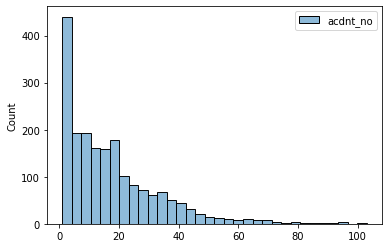

In [ ]:
# 사고건수 분포 파악
# x축이 건수, y축이 격자개수
# 사고가 0 ~ 50건인 격자가 압도적으로 많아보임
sns.histplot(data=accdent_by_grid)
plt.show()

In [ ]:
# 사고 건수별로 내림차순 정렬
accdent_by_grid.sort_values(by='acdnt_no', ascending=False)

,acdnt_no
gid,
다사58b46a,103
다사57b45a,96
다사59a47a,96
다사58a44a,95
다사59a44b,93
...,...
다사59a48b,1
다사59a57b,1
다사59a63b,1


In [ ]:
top5_acc_grid

Index(['다사58b46a', '다사57b45a', '다사59a47a', '다사58a44a', '다사59a44b', '다사58b45a',
       '다사65a46a', '다사60a45a', '다사58a60a', '다사49b42b',
       ...
       '다사56b52a', '다사56b56a', '다사47a40b', '다사48a53b', '다사49b52a', '다사57a46b',
       '다사58b42b', '다사58b51b', '다사46b42b', '다사58b53a'],
      dtype='object', name='gid', length=200)

In [ ]:
top5_acc_grid = accdent_by_grid.sort_values(by='acdnt_no', ascending=False).index[:200]
top5_geo_acc_grid = geo_grids[[g in top5_acc_grid for g in geo_grids['gid']]]

In [ ]:
# 교통사고 발생 상위 5개 격자는 어디일까
top5_geo_acc_grid.explore(tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', attr='Google')